In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/work/S2/NLP/medal
#%cd /content/drive/MyDrive/Dauphine/M2/S2/NLP/medal

/content/drive/MyDrive/work/S2/NLP/medal


In [ ]:
%pip install transformers fasttext -q

## Pre-training

In [ ]:
ARGS = {
    "savedir":"./csv_logs",
    "model":"electra",
    "data_dir":"./data/pretraining",
    "data_filename":"medal.csv",
    "adam_path":"./toy_data/valid_adam.txt",
    "embs_path":"./data",
    "use_scheduler":True,
    "lr":2e-6,
    "clip":0,
    "dropout":0.1,
    "epochs":10,
    "accum_num":1,
    "save_every":1,
    "eval_every":200000,
    "batchsize":8,
    "hidden_size":512,
    "rnn_layers":3,
    "da_layers":1,
    "pretrained_model": "./models/electra.pt"
    }

In [ ]:
import argparse
import os
import time
import pandas as pd

import torch
import torch.optim as optim
from torch import nn

from models.rnn import RNN
from models.lstm_sa import RNNAtt
from models.electra import Electra
from transformers import ElectraTokenizer
from utils import load_dataframes, load_model, train_loop
from models.tokenizer_and_dataset import \
    FastTextTokenizer, EmbeddingsDataset, HuggingfaceDataset

from torch.utils.tensorboard import SummaryWriter

EXPERIMENT_DIR = ARGS.get('savedir')
N_EPOCHS = ARGS.get('epochs')
BATCH_SIZE = ARGS.get('batchsize')
N_CPU_CORES = ARGS.get('ncpu')
MODEL_TYPE = ARGS.get('model')
USE_PRETRAIN = True

DEVICE = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

# Load data

train, valid, test, label_to_ix = load_dataframes (
                                    data_dir=ARGS.get('data_dir'), 
                                    data_filename=ARGS.get('data_filename'),
                                    adam_path=ARGS.get('adam_path')
                                    )
print("Data loaded")

# Create tokenizer objects
if MODEL_TYPE == "electra":
    tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
else:
    # Create word index and load Fasttext embedding matrix
    tokenizer = FastTextTokenizer(verbose=True)
    tokenizer.build_word_index(train.TEXT, valid.TEXT, test.TEXT, list(label_to_ix.keys()))
    tokenizer.build_embedding_matrix(ARGS.get('embs_path'))

# Create torch Dataset objects
if MODEL_TYPE == "electra":
    train_data = HuggingfaceDataset(train, tokenizer=tokenizer, device=DEVICE)
    valid_data = HuggingfaceDataset(valid, tokenizer=tokenizer, device=DEVICE)
else:
    train_data = EmbeddingsDataset(train, tokenizer=tokenizer, device=DEVICE)
    valid_data = EmbeddingsDataset(valid, tokenizer=tokenizer, device=DEVICE)
print("Dataset created")

# Define network, loss function and optimizer

net = Electra(
        output_size=len(label_to_ix),
        device=DEVICE,
    )
print('model: {}'.format(net))


if torch.cuda.device_count() > 1:
    net.to(DEVICE)
    print("Using", torch.cuda.device_count(), "GPUs")
    net = nn.DataParallel(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), ARGS.get('lr'))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=8) \
    if ARGS.get('use_scheduler') else None

# Create save directory
time_stamp = time.strftime("%m-%d-%H-%M", time.localtime())
save_dir = os.path.join(EXPERIMENT_DIR, time_stamp)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save configs
model_desc_output = [": ".join([str(k), str(v)]) for k, v in ARGS.items()]
with open(os.path.join(save_dir, 'configs.txt'), 'w') as file:
    file.writelines("\n".join(model_desc_output))

# Set up tensorboard
writer = SummaryWriter(f"runs/{MODEL_TYPE}-{time_stamp}")

# Train network
net, logs = train_loop(
    net, MODEL_TYPE, optimizer, criterion, train_data, valid_data, save_dir=save_dir, n_epochs=N_EPOCHS, \
        batch_size=BATCH_SIZE, verbose=True, scheduler=scheduler, save_every=ARGS.get('save_every'), \
        eval_every=ARGS.get('eval_every'), clip=ARGS.get('clip'), writer=writer, accum_num=ARGS.get('accum_num'),
)

# Save Model
torch.save(net, os.path.join(save_dir, 'model.pt'))

# Save Logs
log_df = pd.DataFrame(logs)
log_df.to_csv(os.path.join(save_dir, 'logs.csv'))


## Mortality prediction

In [ ]:
import multiprocessing
CORES = multiprocessing.cpu_count() # Count the number of cores in a computer

ARGS = {
    "savedir":"./csv_logs",
    "model":"electra",
    "data_dir":"./data/downstream",
    "data_filename":"mimic.csv",
    "adam_path":"./toy_data/valid_adam.txt",
    "embs_path":"./data",
    "task":"mimic-mortality",
    "use_scheduler":True,
    "lr":2e-6,
    "clip":0,
    "dropout":0.1,
    "epochs":3,
    "save_every":1,
    "eval_every":10000,
    "batchsize":8,
    "hidden_size":512,
    "da_layers":1,
    "ncpu":CORES,
    "pretrained_model": "./models/electra.pt"
    }

In [ ]:
import os
import time
import sys

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader

from transformers import ElectraTokenizer
from downstream.utils import load_mimic_mortality, load_mimic_diagnosis, load_model, predict, evaluate, train_loop
from downstream.electra import Electra
import pandas as pd
import numpy as np

from downstream.tokenizer_and_dataset import FastTextTokenizer, MimicDataset, HuggingfaceDataset

from torch.utils.tensorboard import SummaryWriter


EXPERIMENT_DIR = ARGS.get('savedir')
N_EPOCHS = ARGS.get('epochs')
BATCH_SIZE = ARGS.get('batchsize')
N_CPU_CORES = ARGS.get('ncpu')
MODEL_TYPE = ARGS.get('model')
TASK = ARGS.get('task')
TEST = ARGS.get('test')
USE_PRETRAIN = True if ARGS.get('pretrained_model') else False

if TEST and not USE_PRETRAIN:
    raise Exception("no model preovided for testing")

if not USE_PRETRAIN:
    print("No pretrained model provided. Will train from scratch.")

# Prelim
torch.set_num_threads(N_CPU_CORES)
DEVICE = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

# Load data
if TASK in ['mimic-mortality']:
    train, valid, test = load_mimic_mortality(ARGS.get('data_dir'), ARGS.get('data_filename'))
elif TASK in ['mimic-diagnosis']:
    train, valid, test, diag_to_idx = \
        load_mimic_diagnosis(ARGS.get('data_dir'), ARGS.get('data_filename'), ARGS.get('diag_to_idx_path'))
print("Data loaded")

# Create tokenizer objects

tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

if TASK in ['mimic-mortality']:
    output_size = 1
    label_col = 'LABEL_NUM'
elif TASK in ['mimic-diagnosis']:
    output_size = len(diag_to_idx)
    label_col = 'DIAG'

# Create torch Dataset objects

if TEST:
    test_data = HuggingfaceDataset(test, tokenizer=tokenizer, task=TASK, label_col=label_col, output_size=output_size, device=DEVICE)
else:
    train_data = HuggingfaceDataset(train, tokenizer=tokenizer, task=TASK, label_col=label_col, output_size=output_size, device=DEVICE)
    valid_data = HuggingfaceDataset(valid, tokenizer=tokenizer, task=TASK, label_col=label_col, output_size=output_size, device=DEVICE)

print("Dataset created")

# Define network, loss function and optimizer

net = Electra(
    output_size=output_size,
    device=DEVICE,
)
if USE_PRETRAIN:
    net = load_model(net, ARGS.get('pretrained_model'), DEVICE)

print('model: {}'.format(net))

if TASK in ['mimic-mortality', 'mimic-diagnosis']:
    criterion = nn.BCELoss()
if not TEST:
    optimizer = optim.Adam(net.parameters(), ARGS.get('lr'))
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=8) \
        if ARGS.get('use_scheduler') else None

# Create save directory
time_stamp = time.strftime("%m-%d-%H-%M", time.localtime())
save_dir = os.path.join(EXPERIMENT_DIR, time_stamp)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save configs
model_desc_output = [": ".join([str(k), str(v)]) for k, v in ARGS.items()]
with open(os.path.join(save_dir, 'configs.txt'), 'w') as file:
    file.writelines("\n".join(model_desc_output))

if not TEST:
    writer = SummaryWriter(f"runs/{TASK}/{MODEL_TYPE}-{time_stamp}")
    # Train network
    net, logs = train_loop(
        net, optimizer, criterion, train_data, valid_data, save_dir=save_dir, task=TASK, n_epochs=N_EPOCHS, \
            batch_size=BATCH_SIZE, verbose=True, scheduler=scheduler, save_every=ARGS.get('save_every'), \
            eval_every=ARGS.get('eval_every'), writer=writer,
    )
else:
    # Test
    logs = {k: [] for k in ['test_loss', 'test_metric']}
    if TASK == 'mimic-diagnosis':
        logs['test_top_5_recall'] = []
        logs['test_top_30_recall'] = []
    test_loader = DataLoader(
        range(len(test)), 
        shuffle=False, 
        batch_size=BATCH_SIZE
    )
    if TASK == 'mimic-mortality':
        test_preds = predict(net, test_loader, test_data, verbose=True).cpu().numpy()
        np.save(os.path.join(save_dir, 'test_preds.npy'), test_preds)
        test_loss, test_metric = evaluate(net, test_loader, test_data, criterion, verbose=True, task=TASK)
    elif TASK == 'mimic-diagnosis':
        test_loss, test_metrics = evaluate(net, test_loader, test_data, criterion, verbose=True, task=TASK)
        test_metric = test_metrics['top_10_recall']
    print(f"Test Loss: {test_loss:.4f} \tTest Metric:{test_metric:.4f}")
    if TASK == 'mimic-diagnosis':
        print(f"Test Top 5 Recall: {test_metrics['top_5_recall']:.4f} \tTest Top 30 Recall:{test_metrics['top_30_recall']:.4f}")
    print("="*50)
    logs['test_loss'].append(test_loss)
    logs['test_metric'].append(test_metric)
    if TASK == 'mimic-diagnosis':
        logs['test_top_5_recall'].append(test_metrics['top_5_recall'])
        logs['test_top_30_recall'].append(test_metrics['top_30_recall'])

# Save Model
if not TEST:
    torch.save(net.state_dict(), os.path.join(save_dir, 'model.pt'))

# Save Logs
log_df = pd.DataFrame(logs)
log_df.to_csv(os.path.join(save_dir, 'logs.csv'))

Data loaded
Dataset created


Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


pretrained: odict_keys(['electra.embeddings.word_embeddings.weight', 'electra.embeddings.position_embeddings.weight', 'electra.embeddings.token_type_embeddings.weight', 'electra.embeddings.LayerNorm.weight', 'electra.embeddings.LayerNorm.bias', 'electra.embeddings_project.weight', 'electra.embeddings_project.bias', 'electra.encoder.layer.0.attention.self.query.weight', 'electra.encoder.layer.0.attention.self.query.bias', 'electra.encoder.layer.0.attention.self.key.weight', 'electra.encoder.layer.0.attention.self.key.bias', 'electra.encoder.layer.0.attention.self.value.weight', 'electra.encoder.layer.0.attention.self.value.bias', 'electra.encoder.layer.0.attention.output.dense.weight', 'electra.encoder.layer.0.attention.output.dense.bias', 'electra.encoder.layer.0.attention.output.LayerNorm.weight', 'electra.encoder.layer.0.attention.output.LayerNorm.bias', 'electra.encoder.layer.0.intermediate.dense.weight', 'electra.encoder.layer.0.intermediate.dense.bias', 'electra.encoder.layer.0.ou

  0%|          | 0/25602 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
 39%|███▉      | 10001/25602 [36:33<329:00:42, 75.92s/it] 

End of iteration 10000.0
Train Loss: 0.6479 	Train Metric:0.6593
Valid Loss: 0.5829 	Valid Metric:0.7011



 78%|███████▊  | 20000/25602 [1:13:36<173:46:21, 111.67s/it]

End of iteration 20000.0
Train Loss: 0.5922 	Train Metric:0.6959
Valid Loss: 0.5316 	Valid Metric:0.7429



100%|██████████| 3503/3503 [06:00<00:00,  9.72it/s]


End of epoch 0
Train Loss: 0.5699 	Train Metric:0.7109
Valid Loss: 0.4964 	Valid Metric:0.7679



 39%|███▉      | 10000/25602 [37:15<476:40:42, 109.99s/it]

End of iteration 10000.0
Train Loss: 0.4614 	Train Metric:0.7852
Valid Loss: 0.4738 	Valid Metric:0.7830



 78%|███████▊  | 20000/25602 [1:14:00<170:34:43, 109.62s/it]

End of iteration 20000.0
Train Loss: 0.4505 	Train Metric:0.7902
Valid Loss: 0.4988 	Valid Metric:0.7729



100%|██████████| 3503/3503 [05:52<00:00,  9.92it/s]


End of epoch 1
Train Loss: 0.4460 	Train Metric:0.7925
Valid Loss: 0.4674 	Valid Metric:0.7869



 39%|███▉      | 10001/25602 [37:08<338:32:07, 78.12s/it] 

End of iteration 10000.0
Train Loss: 0.4157 	Train Metric:0.8094
Valid Loss: 0.4533 	Valid Metric:0.7943



 78%|███████▊  | 20000/25602 [1:14:24<174:36:07, 112.20s/it]

End of iteration 20000.0
Train Loss: 0.4095 	Train Metric:0.8134
Valid Loss: 0.4619 	Valid Metric:0.7930



100%|██████████| 3503/3503 [05:57<00:00,  9.80it/s]


End of epoch 2
Train Loss: 0.4079 	Train Metric:0.8141
Valid Loss: 0.4281 	Valid Metric:0.8089



## Test models

In [ ]:
import os
import time
import sys

import torch
from torch import nn
from torch.utils.data import DataLoader

from transformers import ElectraTokenizer
from downstream.utils import load_mimic_mortality, load_model, predict, evaluate
from downstream.electra import Electra
import pandas as pd
import numpy as np

from downstream.tokenizer_and_dataset import FastTextTokenizer, MimicDataset, HuggingfaceDataset

from random import sample


model_ckpt = "./csv_logs/04-15-09-18/model.pt"

def test_model_on_subsample(model_ckpt=None):

  # Load data

  train, valid, test = load_mimic_mortality("./data/downstream", "mimic.csv")

  # Create tokenizer objects

  tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

  output_size = 1
  label_col = 'LABEL_NUM'
  TASK = "mimic-mortality"

  torch.set_num_threads(4)
  DEVICE = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")


  # Create save directory
  time_stamp = time.strftime("%m-%d-%H-%M", time.localtime())
  save_dir = os.path.join('./csv_logs', time_stamp)
  if not os.path.exists(save_dir):
      os.makedirs(save_dir)

  # Create torch Dataset objects

  test_data = HuggingfaceDataset(test, tokenizer=tokenizer, task=TASK, label_col=label_col, output_size=output_size, device=DEVICE)

  # Define network, loss function and optimizer

  net = Electra(
      output_size=output_size,
      device=DEVICE,
  )

  if model_ckpt:
    net = load_model(net, model_ckpt, DEVICE)

  criterion = nn.BCELoss()

  # sents, label = test_data[0:3]
  # sents = torch.Tensor(sents, device='cpu')
  # print(sents)
  # print(net(sents))

  # Test

  logs = {k: [] for k in ['test_loss', 'test_metric']}

  sample_map = sample(range(len(test)),int(len(test)/4)) 
  test_loader = DataLoader(
      sample_map, 
      shuffle=False, 
      batch_size=8
  )

  test_loss, test_metric = evaluate(net, test_loader, test_data, criterion, verbose=True, task=TASK)

  logs['test_loss'].append(test_loss)
  logs['test_metric'].append(test_metric)

  print(logs)

  return logs


df = pd.DataFrame(index=range(5),columns=['test_loss', 'test_metric'])

for i in range(5):
  log = test_model_on_subsample(model_ckpt)
  df.loc[i,'test_loss'] = log.get('test_loss')
  df.loc[i,'test_metric'] = log.get('test_metric')

df

In [ ]:
df.to_csv('medal_dwstream_test.csv')

from google.colab import files

files.download('medal_dwstream_test.csv')

## Vizs

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# loss curves

def get_loss_curve(path):
  name = path.split('/')[-1].split('_')[0]
  df = pd.read_csv(path)
  df = df[df.columns[3:]]
  fig1 = df[df.columns[:2]].plot() #loss
  fig2 = df[df.columns[2:]].plot() #accuracy
  fig1.figure.savefig(f'{name}_loss.png')
  fig2.figure.savefig(f'{name}_accuracy.png')
  files.download(f'{name}_loss.png')
  files.download(f'{name}_accuracy.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

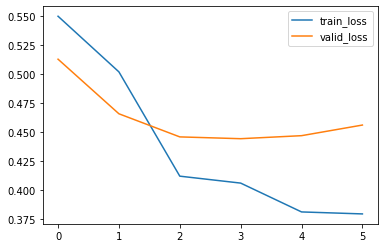

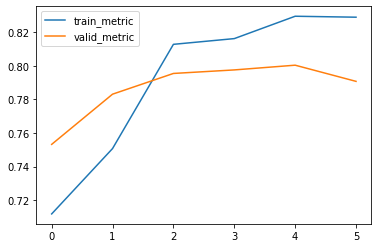

In [ ]:
get_loss_curve('./figures/base_losscurve.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

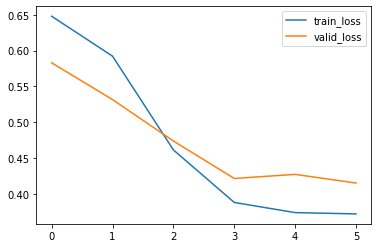

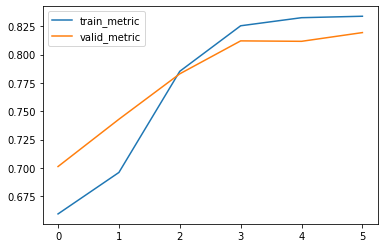

In [ ]:
get_loss_curve('./figures/medal_losscurve.csv')

In [ ]:
def get_boxplot(path1,path2):

  name1 = path1.split('/')[-1].split('_')[0]
  name2 = path2.split('/')[-1].split('_')[0]
  
  df1 = pd.read_csv(path1)[['test_metric']]
  df1['test_metric']=df1['test_metric'].str.replace('[','').str.replace(']','')
  
  df2 = pd.read_csv(path2)[['test_metric']]
  df2['test_metric']=df2['test_metric'].str.replace('[','').str.replace(']','')

  df = pd.merge(df1,df2,left_index=True,right_index=True,suffixes=(f'_{name1}', f'_{name2}'))
  df = df.apply(pd.to_numeric)

  fig = df.boxplot() #accuracy
  fig.figure.savefig('boxplot_accuracy.png')
  files.download('boxplot_accuracy.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

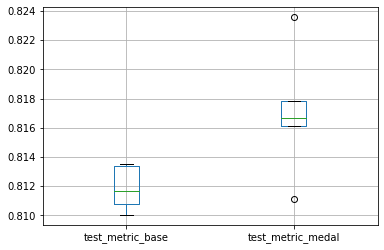

In [ ]:
path1 = './figures/base_dwstream_test.csv'
path2 = './figures/medal_dwstream_test.csv'

get_boxplot(path1,path2)



In [ ]:
name1 = path1.split('/')[-1].split('_')[0]
name2 = path2.split('/')[-1].split('_')[0]

df1 = pd.read_csv(path1)[['test_metric']]
df1['test_metric']=df1['test_metric'].str.replace('[','').str.replace(']','')

df2 = pd.read_csv(path2)[['test_metric']]
df2['test_metric']=df2['test_metric'].str.replace('[','').str.replace(']','')

df = pd.merge(df1,df2,left_index=True,right_index=True,suffixes=(f'_{name1}', f'_{name2}'))
df = df.apply(pd.to_numeric)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
